# Unsupervised methods in NLP



### Themes:
- Part I: Analyzing topics (unsupervised NLP basics)
    - Term weighting with TF-IDF
    - Document clustering
- Part II: Transfer learning (modern NLP)
    - Word vectors (word2vec)
    - Pre-trained language models (ELMo, BERT)



## Overview

- Goal: identify meaningful relationships in raw text *internally*
    - No need for manual annotation (as in supervised learning)
- Unsupervised methods involve:
    - Counting frequencies of word occurence in different contexts
    - Counting/estimating frequencies of word co-occurrence in different contexts
    - Machine learning methods for clustering objects (e.g. documents)
    - Machine learning methods for modeling word sequences (language modeling)


# Part I: Analyzing topics (unsupervised NLP basics)

## Term weighting with TF-IDF

### Recap from "Basic NLP" lecture: _tf-idf weighting_

* TF = term frequency *tf(t, d)*, how many times the term _t_ appears in document *d*
* DF = document frequency *df(t)*, in how many documents the term *t* appears
* IDF = inverse document frequency, *m/df(t)*, where *m* is the total number of documents in your collection
* TF-IDF = **tf(t, d) * idf(t)**
    * Usually calculated using logaritmic (sublinear) scale --> tf(t, d) * log(idf(t))
    
* common in information retrieval, also used in document classification and clustering
* scale down the impact of tokens that occur very frequently in many documents and are hence empirically less informative/distinctive than words that occur in a small fraction of the documents

More reading on [tf-idf](https://nlp.stanford.edu/IR-book/html/htmledition/term-frequency-and-weighting-1.html) and [scaling and normalization variations](https://nlp.stanford.edu/IR-book/html/htmledition/variant-tf-idf-functions-1.html) (in the context of information retrieval).

In [2]:
### Calculate TF-IDF scores on a corpus

import json
from sklearn.feature_extraction.text import TfidfVectorizer

with open("Data/patents.txt", "rt", encoding="utf-8") as f:
    documents = [line.strip() for line in f.readlines()]

# Set parameters and initialize
tfidf_vectorizer = TfidfVectorizer(min_df=2, use_idf=True, sublinear_tf=True, max_df=1.0, max_features=5000)
# Tip: the vectorizer also supports extracting n-gram features (common short sequences of words), which may be more descriptive but also much less frequent

# Calcualate term-document matrix with tf-idf scores
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Check matrix shape
tfidf_matrix.toarray().shape # N_docs x N_terms

(13990, 5000)

In [3]:
documents[0]

"A fund-raising computer network and method for simplifying and inducing the giving of monetary contributions by a multiplicity of prospective contributors consisting of a computer with communication circuitry for communicating over a computer network data sets comprised of requests soliciting the making of monetary contributions to a plurality of remote prospective contributors' computers and, a means for receiving data sets comprised of contributions from the remote contributors' respective computers communicated over a computer network. The network and method induces and simplifies the making of contributions. Contributions include political contributions, charitable contributions, and religious contributions. Requests for contributions include multi-media presentations communicated to prospective contributors' computers which are networked to computer networks."

In [4]:
# Inspect terms in vocabulary
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])

['00', '000', '10', '100', '101', '102', '103', '104', '105', '106']
['yen', 'yet', 'yield', 'yields', 'you', 'your', 'zero', 'zip', 'zone', 'zones']


In [5]:
tfidf_matrix[:,tfidf_vectorizer.get_feature_names().index('record')].toarray() # Get doc vector for term

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.16807321],
       [0.        ],
       [0.        ]])

In [6]:
## Inspect document frequencies (counts) of terms

from collections import Counter
terms_in_docs = tfidf_vectorizer.inverse_transform(tfidf_matrix)
token_counter = Counter()
for terms in terms_in_docs:
    token_counter.update(terms)

for term, count in token_counter.most_common(20):
    print("%d\t%s" % (count, term))

13656	the
13433	and
12903	to
12876	of
11967	for
9739	in
9380	is
9316	an
7418	or
7404	system
7262	with
7213	method
6626	by
6495	on
6194	that
6152	from
5997	are
5601	be
5312	one
5000	at


In [7]:
# Alternatively: Inspect IDF values directly
features = tfidf_vectorizer.get_feature_names()
print(sorted(zip(features,tfidf_vectorizer._tfidf.idf_),key=lambda x:x[1])[:20])

[('the', 1.0241620550548614), ('and', 1.040625458906476), ('to', 1.080876924928241), ('of', 1.0829714914595021), ('for', 1.1561778445190274), ('in', 1.3621731480967052), ('is', 1.399727898607335), ('an', 1.406573577282861), ('or', 1.6343699885437601), ('system', 1.6362588180313868), ('with', 1.6556212991271178), ('method', 1.6623906832698014), ('by', 1.747262052645059), ('on', 1.767227662891772), ('that', 1.8146717506700432), ('from', 1.8214744979927957), ('are', 1.8469881854243315), ('be', 1.9152905889132321), ('one', 1.9682576182823426), ('at', 2.028776373314382)]


In [8]:
## Inspect top terms per document

features = tfidf_vectorizer.get_feature_names()
for doc_i in range(5):
    print("\nDocument %d, top terms by TF-IDF" % doc_i)
    for term, score in sorted(list(zip(features,tfidf_matrix.toarray()[doc_i])), key=lambda x:-x[1])[:5]:
        print("%.2f\t%s" % (score, term))


Document 0, top terms by TF-IDF
0.41	contributions
0.36	contributors
0.23	prospective
0.23	computers
0.22	comprised

Document 1, top terms by TF-IDF
0.40	checking
0.37	name
0.24	code
0.24	real
0.23	bank

Document 2, top terms by TF-IDF
0.32	additional
0.26	basic
0.25	server
0.25	depending
0.24	selected

Document 3, top terms by TF-IDF
0.37	taxable
0.28	person
0.28	sum
0.25	periodic
0.24	money

Document 4, top terms by TF-IDF
0.32	translation
0.29	currency
0.17	optimal
0.16	target
0.16	dynamic


## Document clustering

- Clustering: grouping of similar objects in order to structure a set
    - E.g., clustering documents in a corpus -> reveal common topics and provide overview
- TF-IDF weighting for extracting meaningful *features* of documents, highlighting descriptive terms
- Goal: Given features, calculate similarities between documents and assign them into clusters

- The term-document matrix (`tfidf_matrix`) represents the corpus as tf-idf weights (features)
    - Each document represented as a (row) vector
    - Document vectors are sparse:
        - Dimensionality equal to the number of terms extracted from the corpus
        - Non-zero values only for the fraction of terms in document

In [9]:
print(tfidf_matrix.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
print("Document vector length:", tfidf_matrix.shape[1])
for i in range(5):
    print("Non-zero dimensions for document %d: %d" % (i, len([x for x in tfidf_matrix.toarray()[i] if x > 0])))

Document vector length: 5000
Non-zero dimensions for document 0: 46
Non-zero dimensions for document 1: 45
Non-zero dimensions for document 2: 41
Non-zero dimensions for document 3: 56
Non-zero dimensions for document 4: 94


In [11]:
print("Sample word:", features[1000])
print("Occurs in %d documents" % len([x for x in tfidf_matrix.toarray()[:][1000] if x > 0]))
print("out of %d documents" % len(tfidf_matrix.toarray()))

Sample word: confirmation
Occurs in 80 documents
out of 13990 documents


### Vector space model

- A vector space model encodes meaning as coordinates in a high-dimensional space
    - E.g., tf-idf term vectors describe the topic of a document
- Semantic similarities are measured as distances in the space:
    - For vectors *x* and _y_:
        - Euclidean distance: $$d = \sqrt{ (x_1 - y_1)^2 + (x_2 - y_2)^2 + ... + (x_n - y_n)^2 }$$
        - Cosine similarity (distance = 1-similarity): $$s = cos(\sigma) = \frac{x \cdot y}{|x||y|}$$

- We use vector space notion of semantic similarity to group documents into clusters
    - Find common topics, go from many documents to fewer clusters 

More reading on the [vector space model](https://nlp.stanford.edu/IR-book/html/htmledition/the-vector-space-model-for-scoring-1.html).

### k-means clustering

- We will cluster documents based on their tf-idf vectors 
- and the relatively simple and widely used *k-means* method
    - Takes as argument *k* number of clusters to be found
    - Uses a random initialization (i.e., results can vary between runs)
    - Works according to this pseudo code (from the [Mining Massive Datasets book](http://infolab.stanford.edu/~ullman/mmds/ch7.pdf)):

<code>Initially choose k points that are likely to be in different clusters;
Make these points the centroids of their clusters;
FOR each remaining point p DO 
    find the centroid to which p is closest;
    Add p to the cluster of that centroid;
    Adjust the centroid of that cluster to account for p;
END;</code>

In [12]:
# We use a subset of the documents in clustering for faster calculation and easier interpretation of results
matrix_sample = tfidf_matrix[:1000]

In [13]:
from sklearn.cluster import KMeans

# Do clustering
km = KMeans(n_clusters=30, random_state=123, verbose=0)
km.fit(matrix_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [14]:
import heapq, numpy as np

# Custom function to print top keywords for each cluster
def print_clusters(matrix, clusters, n_keywords=10):
    for cluster in range(min(clusters), max(clusters)+1):
        cluster_docs = [i for i, c in enumerate(clusters) if c == cluster]
        print("Cluster: %d (%d docs)" % (cluster, len(cluster_docs)))
        
        # Keep scores for top n terms
        new_matrix = np.zeros((len(cluster_docs), matrix.shape[1]))
        for cluster_i, doc_vec in enumerate(matrix[cluster_docs].toarray()):
            for idx, score in heapq.nlargest(n_keywords, enumerate(doc_vec), key=lambda x:x[1]):
                new_matrix[cluster_i][idx] = score

        # Aggregate scores for kept top terms
        keywords = heapq.nlargest(n_keywords, zip(new_matrix.sum(axis=0), features))
        print(', '.join([w for s,w in keywords]))
        print()


In [15]:
km.labels_

array([27, 27, 22, 14, 21, 14,  3, 10,  5,  1,  0, 24, 21, 26,  0,  8, 25,
       20, 15, 15, 17, 21, 21,  2, 28, 21,  7, 12, 19,  2, 19, 15, 21, 12,
       20,  6,  8, 10, 11, 27, 15, 17,  5,  4, 14,  0, 28,  4, 29, 24, 27,
        1, 17,  6, 12, 27, 21,  6, 18, 20, 21,  9,  9,  6,  9, 12,  7,  0,
       13, 19, 15, 21, 21,  4, 10,  0,  9,  9,  1,  9, 18, 12,  0,  3,  0,
       10, 18,  6, 12,  0, 15,  6, 20,  0, 10, 10, 10, 18, 15,  6, 25,  9,
       23,  8,  0, 14, 26, 12,  5, 24,  0, 27, 26,  6, 10, 21,  3, 15, 26,
        9,  9,  0, 20, 27, 18, 19, 27,  7, 20, 22,  8,  9, 17, 24, 15, 27,
       23,  0, 18, 14,  7,  8,  1,  8, 29,  7, 24,  0,  5,  1,  4,  6,  1,
       13, 18,  0, 15, 20,  3, 10, 22, 27, 12,  4,  8, 23,  9, 18,  0,  0,
       17,  6, 15,  5,  6,  6,  6,  5,  3, 17,  8,  8,  7,  6, 25, 15,  0,
       26, 23, 15, 24,  4, 20, 27, 17,  7, 18,  8, 14, 25, 22, 14,  8, 16,
       17,  8,  0, 28, 24, 19,  7,  4, 19, 18, 14, 17, 26,  0,  6, 18, 22,
       15,  8,  4, 27,  0

In [16]:
print_clusters(matrix_sample, km.labels_)

Cluster: 0 (63 docs)
network, content, maintaining, users, lease, process, portal, server, probability, devices

Cluster: 1 (35 docs)
group, master, accounts, account, dependent, strategy, level, scope, parameter, linking

Cluster: 2 (25 docs)
firm, fee, organization, patent, charge, pocket, trademark, client, separate, bills

Cluster: 3 (22 docs)
note, stock, forward, holder, unit, contract, remarketing, structuring, trustee, obligation

Cluster: 4 (46 docs)
capital, business, tax, cost, company, intellectual, equity, profit, enterprise, evaluation

Cluster: 5 (21 docs)
goods, term, products, working, unit, attributes, services, retrieving, upgraded, reached

Cluster: 6 (59 docs)
card, account, credit, transaction, customer, rebate, financial, second, device, revolve

Cluster: 7 (26 docs)
member, valid, telephone, non, members, validity, number, companies, details, identifier

Cluster: 8 (50 docs)
instrument, company, agreement, party, order, financial, vehicle, parameters, date, unde

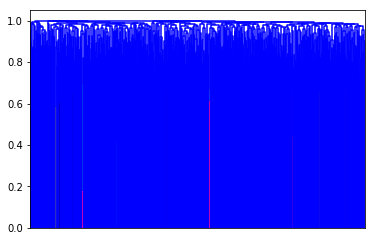

In [18]:
### Hierarchical clustering (alternative approach)

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(matrix_sample.todense(), metric='cosine', method='complete')
_ = dendrogram(Z, no_labels=True) # Plot dentrogram chart

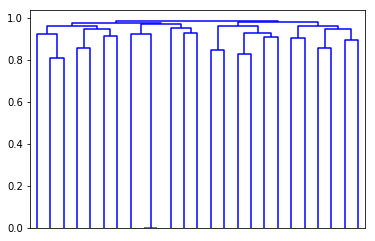

In [19]:
# View dendrogram for subset
Z_ = linkage(matrix_sample.todense()[:25], metric='cosine', method='complete')
_ = dendrogram(Z_, no_labels=True) # Plot dentrogram chart

In [20]:
## Get flat clusters from cluster hierarchy

#clusters = fcluster(Z, 50, criterion='maxclust') # Create fix number of flat clusters
clusters = fcluster(Z, 0.99, criterion='distance') # Create flat clusters by distance threshold

print_clusters(matrix_sample, clusters)

Cluster: 1 (17 docs)
records, organization, presentation, instrument, entity, future, employee, financial, maintaining, predictions

Cluster: 2 (6 docs)
health, savings, care, expenses, premium, techniques, modeling, icon, modeled, methodologies

Cluster: 3 (27 docs)
business, entity, object, case, inter, measuring, value, strategic, performance, model

Cluster: 4 (10 docs)
content, debt, collection, node, debtors, nodes, debtor, strategies, behavioral, deals

Cluster: 5 (120 docs)
capital, instrument, firm, money, investment, intellectual, added, issuer, securities, unit

Cluster: 6 (30 docs)
account, funds, assessment, bank, eps, virtual, day, intelligence, customer, delinquent

Cluster: 7 (153 docs)
asset, estate, parameter, agreement, real, investment, aggregated, charitable, risk, budget

Cluster: 8 (3 docs)
structuring, index, obligation, credit, convertible, bearing, method, complex, liquidity, operating

Cluster: 9 (10 docs)
rebate, card, revolve, expenditures, category, spendi

### Probabilistic topic modeling

- Various machine learning methods for *topic modeling* extend the idea of topic clustering
- The most popular: [Latent Dirichlet Allocation (LDA) method](https://dl.acm.org/doi/pdf/10.1145/2133806.2133826) (see also [gensim library](https://radimrehurek.com/gensim/models/ldamodel.html))
- LDA performs a type of fuzzy clustering into *k* topics:

- 
    - A document can be assigned to *serveral topics*, according to a probability distribution
        - E.g., 68% Topic 6, 21% Topic 5, 11% Topic 2

-     - A topic is described by a *weighting of terms* (probability distribution)
        - The terms reflect term frequencies in documents assigned to the topic
        - The top-10 are often inspected, after some filtering/reranking

In [21]:
## Topic modeling demo
#!pip3 install gensim

# Fast and simple tokenization
new_vectorizer = TfidfVectorizer()
word_tokenizer = new_vectorizer.build_tokenizer()
tokenized_text = [word_tokenizer(doc) for doc in documents]

# Train LDA model
from gensim import corpora, models
dictionary = corpora.Dictionary(tokenized_text)
lda_corpus = [dictionary.doc2bow(text) for text in tokenized_text]
lda_model = models.LdaModel(lda_corpus, id2word=dictionary, num_topics=10)

In [22]:
# Inspect topics
for i, topic in lda_model.show_topics(num_words=10, formatted=False):
    print("Topic", i)
    for term, score in topic:
        print("%.4f\t%s" % (score,term))
    print()

Topic 0
0.0512	and
0.0413	the
0.0377	to
0.0312	loan
0.0245	of
0.0213	for
0.0152	The
0.0123	is
0.0104	system
0.0097	in

Topic 1
0.0480	and
0.0369	the
0.0368	to
0.0299	of
0.0210	system
0.0206	or
0.0155	one
0.0154	for
0.0150	data
0.0149	trading

Topic 2
0.0552	the
0.0338	exchange
0.0336	money
0.0285	contract
0.0213	to
0.0182	primary
0.0173	of
0.0169	participant
0.0160	system
0.0144	settlement

Topic 3
0.0586	the
0.0313	to
0.0283	and
0.0277	is
0.0224	of
0.0198	be
0.0144	that
0.0143	for
0.0127	in
0.0111	The

Topic 4
0.0970	the
0.0400	of
0.0346	to
0.0299	and
0.0211	for
0.0164	The
0.0155	account
0.0152	is
0.0126	an
0.0119	in

Topic 5
0.0428	credit
0.0316	of
0.0300	and
0.0300	virtual
0.0285	real
0.0231	the
0.0227	property
0.0214	in
0.0178	for
0.0165	to

Topic 6
0.0462	the
0.0322	and
0.0317	of
0.0294	risk
0.0293	data
0.0290	for
0.0210	to
0.0166	financial
0.0151	score
0.0125	an

Topic 7
0.0906	the
0.0578	of
0.0309	to
0.0271	and
0.0188	for
0.0158	is
0.0135	in
0.0132	or
0.0125	an
0.0122	The

Topic

In [23]:
tokenized_text[0]

['fund',
 'raising',
 'computer',
 'network',
 'and',
 'method',
 'for',
 'simplifying',
 'and',
 'inducing',
 'the',
 'giving',
 'of',
 'monetary',
 'contributions',
 'by',
 'multiplicity',
 'of',
 'prospective',
 'contributors',
 'consisting',
 'of',
 'computer',
 'with',
 'communication',
 'circuitry',
 'for',
 'communicating',
 'over',
 'computer',
 'network',
 'data',
 'sets',
 'comprised',
 'of',
 'requests',
 'soliciting',
 'the',
 'making',
 'of',
 'monetary',
 'contributions',
 'to',
 'plurality',
 'of',
 'remote',
 'prospective',
 'contributors',
 'computers',
 'and',
 'means',
 'for',
 'receiving',
 'data',
 'sets',
 'comprised',
 'of',
 'contributions',
 'from',
 'the',
 'remote',
 'contributors',
 'respective',
 'computers',
 'communicated',
 'over',
 'computer',
 'network',
 'The',
 'network',
 'and',
 'method',
 'induces',
 'and',
 'simplifies',
 'the',
 'making',
 'of',
 'contributions',
 'Contributions',
 'include',
 'political',
 'contributions',
 'charitable',
 'cont

In [24]:
# Inspect topics
for i, topic in lda_model.show_topics(num_words=50, formatted=False):
    print("Topic", i)
    printed_terms = 0
    for term, score in topic:
        if printed_terms >= 10:
            break
        elif term in "the of and to for in or The is be may an a with at are on by as from can".split():
            continue
        printed_terms += 1
        print("%.4f\t%s" % (score,term))
    print()

Topic 0
0.0312	loan
0.0104	system
0.0095	that
0.0085	mortgage
0.0083	borrower
0.0080	invention
0.0075	method
0.0058	present
0.0056	lender
0.0052	information

Topic 1
0.0210	system
0.0155	one
0.0150	data
0.0149	trading
0.0115	order
0.0093	orders
0.0092	more
0.0086	transaction
0.0081	market
0.0080	financial

Topic 2
0.0338	exchange
0.0336	money
0.0285	contract
0.0182	primary
0.0169	participant
0.0160	system
0.0144	settlement
0.0140	product
0.0135	secondary
0.0132	order

Topic 3
0.0144	that
0.0072	system
0.0062	processing
0.0056	transactions
0.0052	In
0.0052	electronic
0.0049	transaction
0.0048	process
0.0047	check
0.0047	payment

Topic 4
0.0155	account
0.0119	information
0.0103	user
0.0101	system
0.0082	method
0.0081	data
0.0079	first
0.0071	payment
0.0066	one
0.0061	card

Topic 5
0.0428	credit
0.0300	virtual
0.0285	real
0.0227	property
0.0147	estate
0.0143	world
0.0138	transactions
0.0113	system
0.0097	embodiments
0.0078	In

Topic 6
0.0294	risk
0.0293	data
0.0166	financial
0.0151	score


For visualization of topic models, see, for instance, [pyLDAvis](https://github.com/bmabey/pyLDAvis).

# Part II: Transfer learning (modern NLP)

# Word vectors

- Recap: We used the term-document matrix to understand semantic similarities *between documents* based on overlapping keywords
- Now, we study similarities *between words*, by comparing the close contexts in which they appear
- The comparison is also done in a vector space, see illustration (with only 3 dimensions):

![semantic_space](figs/semspace.svg "Illustration of words embedded in a semantic vector space")

**Simple demo, document context:**
- We can also inspect the term-document matrix vertically, by extracting *column vectors* for terms
- Meaning by context: A term is described by the documents in which it occurs
- The tf-idf scores of the term vector (or word vector) define coordinates in a high-dimensional space
    - Distances can be measured, commonly by the cosine similarity function


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

term_index = 1000
print("Similar terms to:", features[term_index])
# Get most similar terms according to the cosine similarity of their vectors (columns in the term-document matrix)
heapq.nlargest(10, zip(cosine_similarity(tfidf_matrix[:,term_index].todense().T, tfidf_matrix.todense().T)[0], features))


### Better approach: Word co-occurrence matrix

- Look at a more immediate context of word use, e.g., +/- 5 words
- Count word co-occurrence statistics (--> word-word matrix)

**Analyzing word combinations (first-order co-occurrence):**
- Strongly associated pairs of words can be identified using the *pointwise mutual information* (PMI) score:
    - For words x and y: $$pmi(x,y) = \log \frac{p(x,y)}{p(x)p(y)} $$

    - where p(x,y) is estimated as the co-occurrence frequency and p(x) and p(y) as the independent occurence frequencies
- PMI can highlight common combinations of words and topics (e.g., "poor"-"service"; "handsome"-"man" / "beautiful"-"woman")

More reading on: [PMI](https://en.wikipedia.org/wiki/Pointwise_mutual_information) and [other association measures](http://collocations.de/AM/index.html).

**Analyzing word similarity (second-order co-occurrence):**

- "You shall know a word by the company it keeps" (J.R. Firth)
    - The meaning of a word can be understood by the distribution of words it tends to appear in (= distributional hypothesis)
    - Words may be similar although they to not directly co-occur (but share context words) --> 2nd order co-occurrence
- Cosine function between word vectors gives word pair similarity

- Vectors are very sparse: 
    - Vocabulary (dimensionality) grows with corpus size, while context size is small and fixed
    - Similarity can be estimated only when there is an overlap in terms
    - Many rare terms / sparse vectors --> very big corpora needed for good models --> huge memory usage and scalability issues

### Learning dense vectors

More useful vectors through:
- Matrix decomposition approach:
    - Reduce the number of dimensions of the semantic vector space, for instance, using Singular Value Decomposition (SVD)
        - Dimensionality reduction, e.g., from 10k or 100k to 100
    - Also used in Latent Semantic Analysis (LSA), applied to term-document matrix

- Neural network approach:
    - Learning *distributed representations* of concepts explored first by Hinton (1986)
    - word2vec, from 2013, is an important milestone in NLP:
        - Efficient estimation of dense word vectors, enabling fast training
        - Provides high precision vectors when applied to large corpora

- word2vec skip-gram model:
<img src="figs/skipgram_model.svg" alt="skip-gram model" width="800"/>

More reading on [counting vs. predicting word vectors](https://www.aclweb.org/anthology/P14-1023.pdf).

In [ ]:
### Train word vectors

import gensim # Make sure you also have cython installed to accelerate computation!

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Train word2vec model
vectors = gensim.models.Word2Vec(tokenized_text, size=100, window=5, min_count=5, workers=4)

In [ ]:
# Inspect a word vector
vectors.wv['process']

In [ ]:
# Inspect words with vectors most similar to a given word
print("Most similar to:", 'process')
print(vectors.wv.most_similar('process'))
print()

In [ ]:
# ...or combination or words (average vector)
print("Most similar to:", ['process', 'payment'])
print(vectors.wv.most_similar(['process', 'payment']))

In [ ]:
# Inspect cosine similarities between specific words
print(vectors.wv.similarity('technology', 'infrastructure'))
print(vectors.wv.similarity('technology', 'system'))
print(vectors.wv.similarity('technology', 'consumer'))
print(vectors.wv.similarity('technology', 'advanced'))

In [ ]:
## Test for analogies and syntactic regularities (when trained on a large and suitable corpus)

"""
# Man is to King as Woman is to ...
# vec(woman)+vec(king)-vec(man)
print(vectors.most_similar(['woman','king'], negative=['man']))
print()

# Fall is to Fell as Watch is to ...
print(vectors.most_similar(['wear','fell'], negative=['fall']))
print()

print(vectors.most_similar(['Moscow','France'], negative=['Paris']))
print()

print(vectors.most_similar(['London','France'], negative=['Paris']))
"""

### Pre-trained word vectors
- Word vectors trained on large corpora achieve more accurate results
- For instance, word2vec vectors pre-trained on 100B words of Google News text can be [downloaded](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) (1.5GB) and used in the same way as self-trained vectors
- word2vec is also efficient for training your own vectors on mid-sized corpora (e.g., 1B words)
    - Online demo [available here](http://bionlp-www.utu.fi/wv_demo/).

### Vectors as features

- Dense vectors are practical to use especially in neural network models for downstream tasks (e.g., text classification)
- Word vectors (often _word embeddings_) estimated on large amounts of raw text:
    - Embedding layer can serve as an abstraction of text input
    - Reduces reliance on (limited) annotated data in supervised tasks
    - Pre-trained word vectors can make NLP models more accurate and robust
    - This transfer of knowledge about language is called *transfer learning*

<img src="figs/simple_lstm.svg" alt="Neural network with word embeddings" width="400"/>



### Limitations

- Problem: Word vectors produced by word2vec are static with respect to the word
    - I.e., a term always has the same vector representation regardless of how it is used
    - Multiple senses of a word are not distinguished
    - Difficult to capture meaning of sentences (unless fine-tuned on some task)

In [ ]:
# Ambiguous word vector examples

print("Most similar to:", 'data')
print(vectors.wv.most_similar('data'))
print()

# Are the below average vectors less ambiguous?
print("Most similar to:", ['data','transfer'])
print(vectors.wv.most_similar(['data','transfer']))
print()

print("Most similar to:", ['data','storage'])
print(vectors.wv.most_similar(['data','storage']))
print()

## Contextualized word vectors with language modeling

- Word meaning can be disambiguated from the context in an instance of use
    - Compare:
        - "He wrote the **play** himself."
        - "He did **play** with the kids."
        
- Recent methods build on *language modeling* to provide *contextualized* word vectors

- Recap: A language model estimates the probability *P(x)* of seeing a word _x_ following a context, such as:

$$P(\ x\ |\ the\ students\ opened\ their\ )$$

![language modeling (source: mc.ai)](figs/language_modeling.png "Language modeling illustration")
The above suggestions would be deemed much more likely than, e.g., *P(x=keyboard)*, _P(x=follows)_ or *P(x=the)*.

<font color="grey">Lanugage modeling recap: Consider a simple statistical model that estimates the probability of a word given a number of previous words in a text. For instance, given the words *the dog loved to*, the model would deem it much more likely that the next word is _play_ than any word that does not fit semantically or syntactically (e.g., *green*, _played_ or *code*). The probability _p(play | the dog loved to)_ is much higher than for most other words. Such a model can be implemented as a machine learning model, typically a neural network that can take into account a long context, and be trained over large amounts of text. Language models that have a large number of internal trainable parameters can learn complicated regularities of natural language, by learning to accurately predict the next word in a sequence.</font>


For instance, [ELMo](https://allennlp.org/elmo) (released early 2018) uses recurrent neural networks (LSTM) for learning contextualized word vectors through language modeling.

<img src="figs/elmo-language-modeling.png" width="400" alt="Source: https://jalammar.github.io/illustrated-bert/"/>



- ELMo holds internal vector representations as it traverses the word sequence, which can be aggregated to:
    - Contextualized word vectors
    - A sentence vector, reflecting composite meaning

<img src="figs/elmo-embedding.png" width="550" alt="Source: https://jalammar.github.io/illustrated-bert/"/>

In [ ]:
#!pip install tensorflow==1.15
#!pip install "tensorflow_hub>=0.6.0"
#!pip3 install tensorflow_text==1.15

import tensorflow_hub as hub
import tensorflow as tf

# Load ELMo model (takes a little while)
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

def elmo_vectors(sents):
    embeddings = elmo(sents, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        return sess.run(embeddings)
        #sess.run(tf.tables_initializer())
        # return average of ELMo features as sentence vector
        #return sess.run(tf.reduce_mean(embeddings,1))

In [ ]:
# Get contextualized vectors for target word in different sentences

sents = """He wrote the play himself .
He did play with the kids .
His excuse didn't play well .
I saw the play with him .
He can play it by ear .""".split('\n')

target = 'play'

elmo_vecs = elmo_vectors(sents)
word_vecs = []
for i, sent in enumerate(sents):
    word_vecs.append(elmo_vecs[i][sent.split().index(target)])
    print("Sentence:", sent)
    print("Vector for '%s':" % target, word_vecs[-1])
    print()

print("Word vector size:", word_vecs[0].shape)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vec_size = word_vecs[0].shape[0]
print("Similarities between '%s' vector in sentences:" % target)
for i in range(1, len(sents)):
    print("Sent 0-%d:" % i, cosine_similarity(word_vecs[0].reshape((1,vec_size)), 
                                              word_vecs[i].reshape((1,vec_size)))[0][0])

### Even bigger pre-trained models: BERT etc.

- In late 2018, a new, much larger pre-trained language model was released called *BERT* (Bidirectional Encoder Representations from Transformers)
- Transformers can be better parallelized than recurrent network architectures
    - --> Enables training of much larger models than before (on GPU/TPU)
- BERT Large model: 340M parameters ~ 24 Transformer layers x 1024 hidden units x 16 attention heads
    - Compared with ELMo (93.6M parameters), BERT Base (110M)

- Language modeling by learning to predict individual masked words
    - Tricky task that benefits from sophisticated "understanding" of sentences
    - Transformers are good at modeling long-range dependencies

- Computationally very demaning to train (compute cost ~$10k per run, trained on 3.3B words)
- But, fine-tuning model for downstream task (e.g., classification) is quick
- BERT was able to beat the best performing models in a range of NLP tasks at once

Simple BERT model illustration. Each token position is connected to each position in the next layer.
<img src="figs/bert.png" width="400"/>
More illustrated reading on the [Transformer architecture](https://jalammar.github.io/illustrated-transformer/).

Visualization of token-token activations for a sentence per layer and attention head.
<img src="figs/bertvis.png" source="Jesse Vig"/>

- BERT has been particularly successful at *natural language understanding (NLU)* tasks, e.g.:
    - Sentence acceptability
    - Sentiment
    - Paraphrase identification
    - Natural language inference
    - Question answering
    

- Note, however, these models risk learning spurious statistical patterns, rather than real inference (cf. [[1]](https://www.technologyreview.com/s/615126/ai-common-sense-reads-human-language-ai2/)[[2]](https://www.aclweb.org/anthology/P19-1459.pdf))!

BERT has inspired a never-ending stream of successors. See [GLUE (NLU tasks) leaderboard](https://gluebenchmark.com/leaderboard).
<img alt="Map of the BERTology landscape" src="figs/bertology_map.png"/>


Getting started with Transformer-based language models (GPU highly recommended): [huggingface transformers library](https://huggingface.co/transformers/pretrained_models.html)

<code>import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
...</code>

or with `bert-base-finnish-cased-v1` model from TurkuNLP!


Multilingual models include Multilingual BERT `bert-base-multilingual-cased` and the more recent XLM-RoBERTa (XLM-R) `xlm-roberta-base` or `xlm-roberta-large`.